## Original Code From Github

In [15]:

import PIL.Image
import matplotlib.image as mpimg
import scipy.ndimage
import cv2 # For Sobel etc
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

np.set_printoptions(suppress=True, linewidth=200) # Better printing of arrays
plt.rcParams['image.cmap'] = 'jet' # Default colormap is jet


# ## Saddle Point Detection


def getSaddle(gray_img):
    img = gray_img.astype(np.float64)
    gx = cv2.Sobel(img,cv2.CV_64F,1,0)
    gy = cv2.Sobel(img,cv2.CV_64F,0,1)
    gxx = cv2.Sobel(gx,cv2.CV_64F,1,0)
    gyy = cv2.Sobel(gy,cv2.CV_64F,0,1)
    gxy = cv2.Sobel(gx,cv2.CV_64F,0,1)

    S = gxx*gyy - gxy**2
    return S

def nonmax_sup(img, win=10):
    w, h = img.shape
    img_sup = np.zeros_like(img, dtype=np.float64)
    for i,j in np.argwhere(img):
        # Get neighborhood
        ta=max(0,i-win)
        tb=min(w,i+win+1)
        tc=max(0,j-win)
        td=min(h,j+win+1)
        cell = img[ta:tb,tc:td]
        val = img[i,j]
        if np.sum(cell.max() == cell) > 1:
            print(cell.argmax())
        if cell.max() == val:
            img_sup[i,j] = val
    return img_sup

def pruneSaddle(s):
    thresh = 128
    score = (s>0).sum()
    while (score > 10000):
        thresh = thresh*2
        s[s<thresh] = 0
        score = (s>0).sum()

def getMinSaddleDist(saddle_pts, pt):
    best_dist = None
    best_pt = pt
    for saddle_pt in saddle_pts:
        saddle_pt = saddle_pt[::-1]
        dist = np.sum((saddle_pt - pt)**2)
        if best_dist is None or dist < best_dist:
            best_dist = dist
            best_pt = saddle_pt
    return best_pt, np.sqrt(best_dist)


def simplifyContours(contours):
    if contours:  # Ensure contours is not empty
        simplified = []
        for cnt in contours:
            approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
            simplified.append(approx)
        return simplified
    return contours  # Return original if empty


def is_square(cnt, eps=3.0, xratio_thresh = 0.5):
    center = cnt.sum(axis=0)/4

    # Side lengths of rectangular contour
    dd0 = np.sqrt(((cnt[0,:] - cnt[1,:])**2).sum())
    dd1 = np.sqrt(((cnt[1,:] - cnt[2,:])**2).sum())
    dd2 = np.sqrt(((cnt[2,:] - cnt[3,:])**2).sum())
    dd3 = np.sqrt(((cnt[3,:] - cnt[0,:])**2).sum())

    # diagonal ratio
    xa = np.sqrt(((cnt[0,:] - cnt[2,:])**2).sum())
    xb = np.sqrt(((cnt[1,:] - cnt[3,:])**2).sum())
    xratio = xa/xb if xa < xb else xb/xa

    # Check angles
    ta = getAngle(dd3, dd0, xb)
    tb = getAngle(dd0, dd1, xa)
    tc = getAngle(dd1, dd2, xb)
    td = getAngle(dd2, dd3, xa)
    angle_sum = np.round(ta+tb+tc+td)

    is_convex = np.abs(angle_sum - 360) < 5
    angles = np.array([ta,tb,tc,td])
    good_angles = np.all((angles > 40) & (angles < 140))

    # side ratios
    dda = dd0 / dd1
    if dda < 1:
        dda = 1. / dda
    ddb = dd1 / dd2
    if ddb < 1:
        ddb = 1. / ddb
    ddc = dd2 / dd3
    if ddc < 1:
        ddc = 1. / ddc
    ddd = dd3 / dd0
    if ddd < 1:
        ddd = 1. / ddd
    side_ratios = np.array([dda,ddb,ddc,ddd])
    good_side_ratios = np.all(side_ratios < eps)

    return good_angles

def getAngle(a,b,c):
    k = (a*a+b*b-c*c) / (2*a*b)
    if (k < -1):
        k=-1
    elif k > 1:
        k=1
    return np.arccos(k) * 180.0 / np.pi

def getContourVals(cnt, img):
    cimg = np.zeros_like(img)
    cv2.drawContours(cimg, [cnt], 0, color=255, thickness=-1)
    return img[cimg!=0]

def pruneContours(contours, hierarchy, saddle):
    new_contours = []
    new_hierarchies = []

    for i in range(len(contours)):
        cnt = contours[i]
        h = hierarchy[i]

        if h[2] != -1:  # Must be child
            continue

        if len(cnt) != 4:  # Only rectangular contours
            continue

        if cv2.contourArea(cnt) < 8 * 8:  # Minimum area
            continue

        if not is_square(cnt):
            continue

        cnt = updateCorners(cnt, saddle)
        if len(cnt) != 4:
            continue

        new_contours.append(cnt)
        new_hierarchies.append(h)

    if len(new_contours) == 0:
        return [], []

    # Calculate areas before converting contours to a NumPy array
    areas = np.array([cv2.contourArea(cnt) for cnt in new_contours])

    # Ensure there are multiple areas to calculate median
    if len(areas) == 0:
        return [], []

    median_area = np.median(areas)

    # Create mask for filtering
    mask = (areas >= median_area * 0.25) & (areas <= median_area * 2.0)

    # Filter contours and hierarchies using list comprehension instead of boolean indexing
    filtered_contours = [new_contours[i] for i in range(len(new_contours)) if mask[i]]
    filtered_hierarchies = [new_hierarchies[i] for i in range(len(new_hierarchies)) if mask[i]]

    return filtered_contours, filtered_hierarchies


def getContours(img, edges, iters=10):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    edges_gradient = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel)

    contours, hierarchy = cv2.findContours(edges_gradient, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    contours = simplifyContours(contours)  # Ensure this doesn't return irregular shapes

    return contours, hierarchy[0] if hierarchy is not None else None  # Return as list


# ## Corner Processing

def updateCorners(contour, saddle):
    ws = 4 # half window size (+1)
    new_contour = contour.copy()
    for i in range(len(contour)):
        cc,rr = contour[i,0,:]
        rl = max(0,rr-ws)
        cl = max(0,cc-ws)
        window = saddle[rl:min(saddle.shape[0],rr+ws+1),cl:min(saddle.shape[1],cc+ws+1)]
        br, bc = np.unravel_index(window.argmax(), window.shape)
        s_score = window[br,bc]
        br -= min(ws,rl)
        bc -= min(ws,cl)
        if s_score > 0:
            new_contour[i,0,:] = cc+bc,rr+br
        else:
            return []
    return new_contour


def getIdentityGrid(N):
    a = np.arange(N)
    b = a.copy()
    aa,bb = np.meshgrid(a,b)
    return np.vstack([aa.flatten(), bb.flatten()]).T

def getChessGrid(quad):
    quadA = np.array([[0,1],[1,1],[1,0],[0,0]],dtype=np.float32)
    M = cv2.getPerspectiveTransform(quadA, quad.astype(np.float32))
    quadB = getIdentityGrid(4)-1
    quadB_pad = np.pad(quadB, ((0,0),(0,1)), 'constant', constant_values=1)
    C_thing = (np.matrix(M)*quadB_pad.T).T
    C_thing[:,:2] /= C_thing[:,2]
    return C_thing

def findGoodPoints(grid, spts, max_px_dist=5):
    new_grid = grid.copy()
    chosen_spts = set()
    N = len(new_grid)
    grid_good = np.zeros(N,dtype=bool)
    hash_pt = lambda pt: "%d_%d" % (pt[0], pt[1])

    for pt_i in range(N):
        pt2, d = getMinSaddleDist(spts, grid[pt_i,:2].A.flatten())
        if hash_pt(pt2) in chosen_spts:
            d = max_px_dist
        else:
            chosen_spts.add(hash_pt(pt2))
        if (d < max_px_dist):
            new_grid[pt_i,:2] = pt2
            grid_good[pt_i] = True
    return new_grid, grid_good

def getInitChessGrid(quad):
    quadA = np.array([[0,1],[1,1],[1,0],[0,0]],dtype=np.float32)
    M = cv2.getPerspectiveTransform(quadA, quad.astype(np.float32))
    return makeChessGrid(M,1)

def makeChessGrid(M, N=1):
    ideal_grid = getIdentityGrid(2+2*N)-N
    ideal_grid_pad = np.pad(ideal_grid, ((0,0),(0,1)), 'constant', constant_values=1)
    grid = (np.matrix(M)*ideal_grid_pad.T).T
    grid[:,:2] /= grid[:,2]
    grid = grid[:,:2]
    return grid, ideal_grid, M

def generateNewBestFit(grid_ideal, grid, grid_good):
    a = np.float32(grid_ideal[grid_good])
    b = np.float32(grid[grid_good])
    M = cv2.findHomography(a, b, cv2.RANSAC)
    return M

def getGrads(img):
    img = cv2.blur(img,(5,5))
    gx = cv2.Sobel(img,cv2.CV_64F,1,0)
    gy = cv2.Sobel(img,cv2.CV_64F,0,1)

    grad_mag = gx*gx+gy*gy
    grad_phase = np.arctan2(gy, gx)
    grad_phase_masked = grad_phase.copy()
    gradient_mask_threshold = 2*np.mean(grad_mag.flatten())
    grad_phase_masked[grad_mag < gradient_mask_threshold] = np.nan
    return grad_mag, grad_phase_masked, grad_phase, gx, gy

def getBestLines(img_warped):
    grad_mag, grad_phase_masked, grad_phase, gx, gy = getGrads(img_warped)

    # X direction
    gx_pos = gx.copy()
    gx_pos[gx_pos < 0] = 0
    gx_neg = -gx.copy()
    gx_neg[gx_neg < 0] = 0
    score_x = np.sum(gx_pos, axis=0) * np.sum(gx_neg, axis=0)

    # Y direction
    gy_pos = gy.copy()
    gy_pos[gy_pos < 0] = 0
    gy_neg = -gy.copy()
    gy_neg[gy_neg < 0] = 0
    score_y = np.sum(gy_pos, axis=1) * np.sum(gy_neg, axis=1)

    # Choose best internal set of 7 lines
    a = np.array([(offset + np.arange(7) + 1)*32 for offset in np.arange(1,11-2)])
    scores_x = np.array([np.sum(score_x[pts]) for pts in a])
    scores_y = np.array([np.sum(score_y[pts]) for pts in a])

    best_lines_x = a[scores_x.argmax()]
    best_lines_y = a[scores_y.argmax()]
    return (best_lines_x, best_lines_y)


# ## Image Loading and Processing


def loadImage(filepath):
    img_orig = PIL.Image.open(filepath)
    img_width, img_height = img_orig.size

    # Resize
    aspect_ratio = min(500.0/img_width, 500.0/img_height)
    new_width, new_height = ((np.array(img_orig.size) * aspect_ratio)).astype(int)
    img = img_orig.resize((new_width,new_height), resample=PIL.Image.BILINEAR)
    img = img.convert('L') # grayscale
    img = np.array(img)

    return img

def findChessboard(img, min_pts_needed=15, max_pts_needed=25):
    blur_img = cv2.blur(img, (3,3))
    saddle = getSaddle(blur_img)
    saddle = -saddle
    saddle[saddle<0] = 0
    pruneSaddle(saddle)
    s2 = nonmax_sup(saddle)
    s2[s2<100000]=0
    spts = np.argwhere(s2)

    edges = cv2.Canny(img, 20, 250)
    contours_all, hierarchy = getContours(img, edges)
    contours, hierarchy = pruneContours(contours_all, hierarchy, saddle)

    curr_num_good = 0
    curr_grid_next = None
    curr_grid_good = None
    curr_M = None

    for cnt_i in range(len(contours)):
        cnt = contours[cnt_i].squeeze()
        grid_curr, ideal_grid, M = getInitChessGrid(cnt)

        for grid_i in range(7):
            grid_curr, ideal_grid, _ = makeChessGrid(M, N=(grid_i+1))
            grid_next, grid_good = findGoodPoints(grid_curr, spts)
            num_good = np.sum(grid_good)
            if num_good < 4:
                M = None
                break
            M, _ = generateNewBestFit(ideal_grid, grid_next, grid_good)
            if M is None or np.abs(M[0,0] / M[1,1]) > 15 or np.abs(M[1,1] / M[0,0]) > 15:
                M = None
                break
        if M is None:
            continue
        elif num_good > curr_num_good:
            curr_num_good = num_good
            curr_grid_next = grid_next
            curr_grid_good = grid_good
            curr_M = M

        if num_good > max_pts_needed:
            break

    if curr_num_good > min_pts_needed:
        final_ideal_grid = getIdentityGrid(2+2*7)-7
        return curr_M, final_ideal_grid, curr_grid_next, curr_grid_good, spts
    else:
        return None, None, None, None, None

def getUnwarpedPoints(best_lines_x, best_lines_y, M):
    x,y = np.meshgrid(best_lines_x, best_lines_y)
    xy = np.vstack([x.flatten(), y.flatten()]).T.astype(np.float32)
    xy = np.expand_dims(xy,0)

    xy_unwarp = cv2.perspectiveTransform(xy, M)
    return xy_unwarp[0,:,:]

def getBoardOutline(best_lines_x, best_lines_y, M):
    d = best_lines_x[1] - best_lines_x[0]
    ax = [best_lines_x[0]-d, best_lines_x[-1]+d]
    ay = [best_lines_y[0]-d, best_lines_y[-1]+d]
    x,y = np.meshgrid(ax, ay)
    xy = np.vstack([x.flatten(), y.flatten()]).T.astype(np.float32)
    xy = xy[[0,1,3,2,0],:]
    xy = np.expand_dims(xy,0)

    xy_unwarp = cv2.perspectiveTransform(xy, M)
    return xy_unwarp[0,:,:]

# ## Single Image Processing
def processSingle(filename='/content/2.jpg'):
    img = loadImage(filename)
    M, ideal_grid, grid_next, grid_good, spts = findChessboard(img)
    print(M)

    if M is not None:
        M, _ = generateNewBestFit((ideal_grid+8)*32, grid_next, grid_good)
        print(M)
        img_warp = cv2.warpPerspective(img, M, (17*32, 17*32), flags=cv2.WARP_INVERSE_MAP)

        best_lines_x, best_lines_y = getBestLines(img_warp)# Those are the best fit lines
        xy_unwarp = getUnwarpedPoints(best_lines_x, best_lines_y, M) #those are the cordinates of  the corners

        plt.figure(figsize=(20,20))
        plt.subplot(212)
        imshow(img_warp, cmap='Greys_r')
        [plt.axvline(line, color='red', lw=2) for line in best_lines_x];
        [plt.axhline(line, color='green', lw=2) for line in best_lines_y];

        plt.subplot(211)
        axs = plt.axis()
        imshow(img, cmap='Greys_r');
        axs = plt.axis()
        plt.plot(spts[:,1],spts[:,0],'o')
        plt.plot(grid_next[:,0].A, grid_next[:,1].A,'rs')
        plt.plot(grid_next[grid_good,0].A, grid_next[grid_good,1].A,'rs', markersize=12)
        plt.plot(xy_unwarp[:,0], xy_unwarp[:,1], 'go', markersize=15)
        plt.axis(axs)
        plt.savefig('result_single.png', bbox_inches='tight')
        plt.show()


## Break Down of it

### 1-Detect

Start
Processing: ../data/image_0.jpg
Detected Good Points: 67


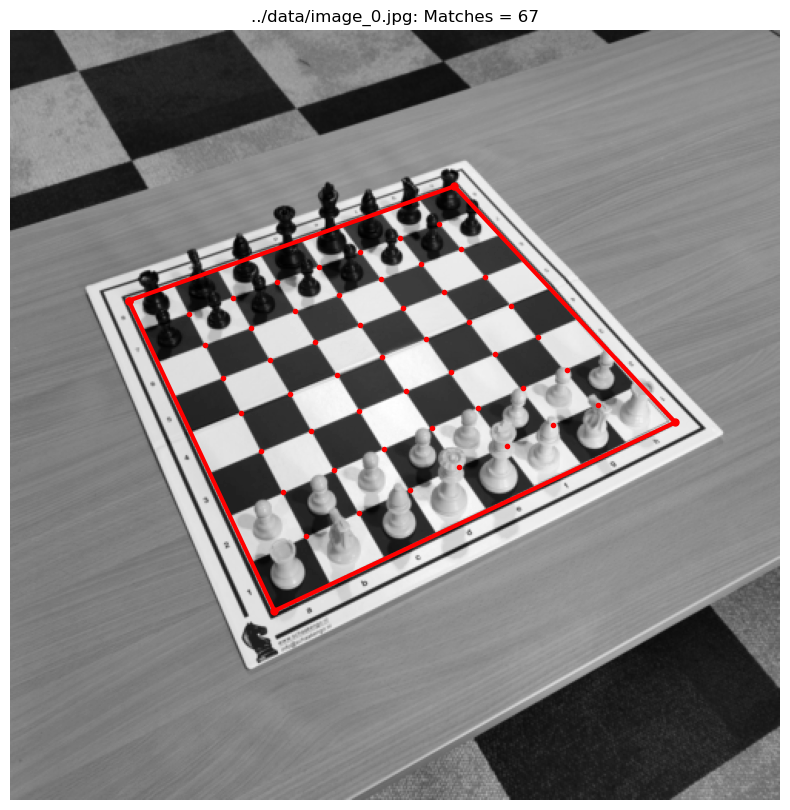

In [16]:

def main():
    # filename = "/content/2.jpg"  # Path to your single image
    filename = "../data/image_0.jpg"  # Path to your single image

    print(f"Processing: {filename}")

    img = loadImage(filename)  # Load the image
    M, ideal_grid, grid_next, grid_good, spts = findChessboard(img)  # Detect chessboard

    fig = plt.figure(figsize=(10, 10))  # Smaller figure since only one image

    if M is not None:
        M, _ = generateNewBestFit((ideal_grid+8)*32, grid_next, grid_good)  # Optimize grid alignment
        img_warp = cv2.warpPerspective(img, M, (17*32, 17*32), flags=cv2.WARP_INVERSE_MAP)  # Warp image

        best_lines_x, best_lines_y = getBestLines(img_warp)  # Get chessboard lines
        xy_unwarp = getUnwarpedPoints(best_lines_x, best_lines_y, M)  # Unwarp points
        board_outline_unwarp = getBoardOutline(best_lines_x, best_lines_y, M)  # Get outline

        plt.imshow(img, cmap='gray')  # Show original image
        plt.plot(xy_unwarp[:, 0], xy_unwarp[:, 1], 'r.')  # Plot detected points
        plt.plot(board_outline_unwarp[:, 0], board_outline_unwarp[:, 1], 'ro-', markersize=5, linewidth=3)  # Outline
        plt.title(f"{filename}: Matches = {np.sum(grid_good)}")
        plt.axis('off')
        print(f"Detected Good Points: {np.sum(grid_good)}")

    else:
        plt.imshow(img, cmap='gray')
        plt.title(f"{filename}: Chessboard Not Found")
        plt.axis('off')
        print("Chessboard detection failed.")

    plt.savefig('result.png', bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    print("Start")
    main()

### Warped

[[  7.66374139  36.21646017 129.12823632]
 [ 15.87200796  -9.29424324 287.11386068]
 [ -0.03710717   0.01691216   1.        ]]
[[   0.20618126    0.97434855 -191.04769509]
 [   0.42701213   -0.25004742  201.87655106]
 [  -0.00099831    0.000455      1.        ]]


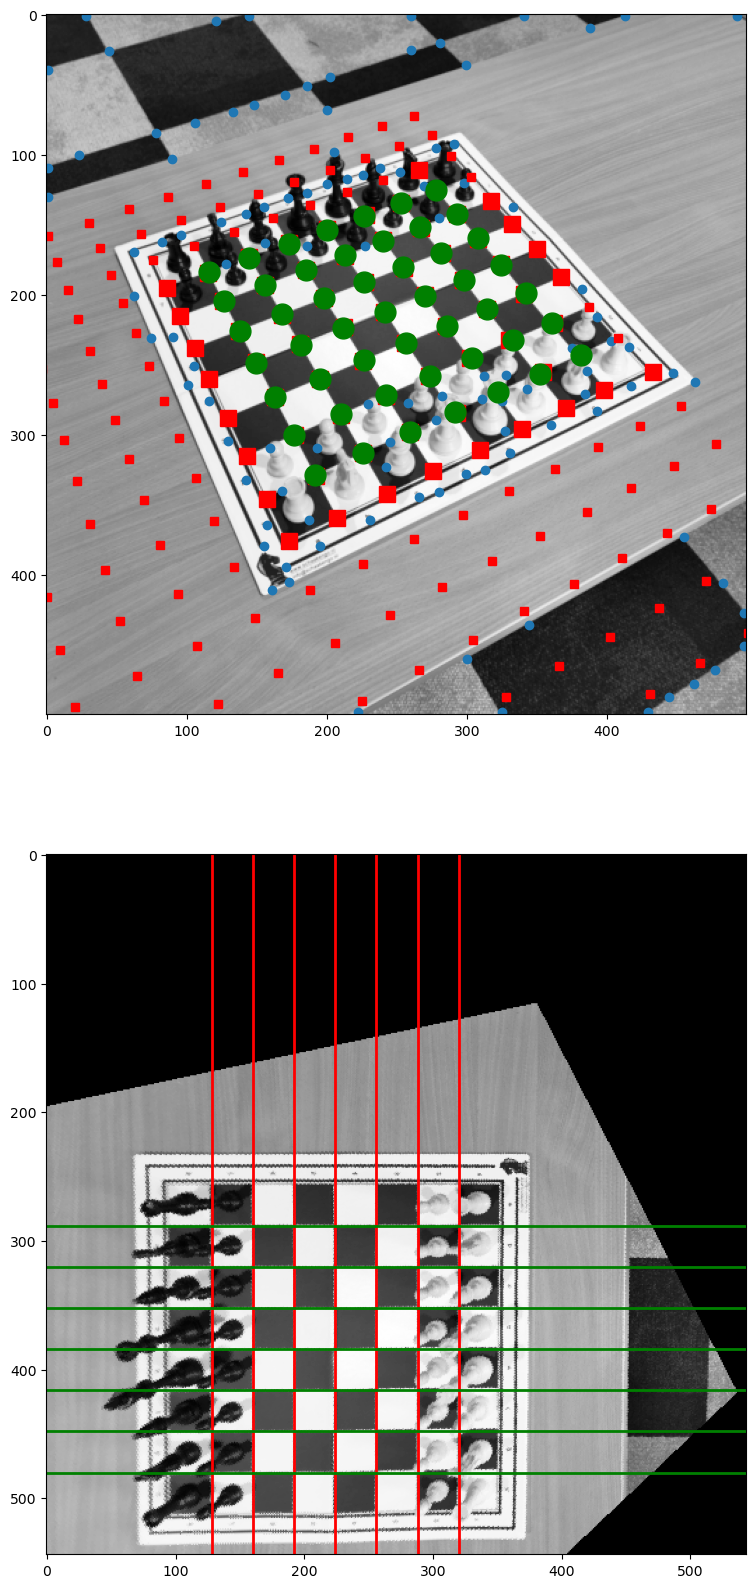

In [17]:
filename = "../data/image_0.jpg"
processSingle(filename)